<h1> Logistic Regression using Spark ML </h1>

Set up bucket

In [2]:
BUCKET='cloud-training-demos-ml'

os.environ['BUCKET'] = BUCKET

In a standalone script, we'd have to do:
<pre>
from pyspark.sql import SparkSession
from pyspark import SparkContext

sc = SparkContext('local', 'logistic')
spark = SparkSession \
    .builder \
    .appName("Logistic regression w/ Spark ML") \
    .getOrCreate()

</pre>
But in Datalab, spark and sc already exist

In [3]:
print spark
print sc

<SparkContext master=yarn appName=pyspark-shell>


In [4]:
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.mllib.regression import LabeledPoint

<h2> Read dataset </h2>

In [5]:
traindays = spark.read \
    .option("header", "true") \
    .csv('gs://{}/flights/trainday.csv'.format(BUCKET))
traindays.createOrReplaceTempView('traindays')

In [6]:
spark.sql("SELECT * from traindays LIMIT 5").show()

+----------+------------+
|   FL_DATE|is_train_day|
+----------+------------+
|2015-01-01|        True|
|2015-01-04|        True|
|2015-01-05|        True|
|2015-01-07|        True|
|2015-01-08|        True|
+----------+------------+



In [7]:
from pyspark.sql.types import StringType, FloatType, StructType, StructField

header = 'FL_DATE,UNIQUE_CARRIER,AIRLINE_ID,CARRIER,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,ORIGIN,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST_CITY_MARKET_ID,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,CANCELLATION_CODE,DIVERTED,DISTANCE,DEP_AIRPORT_LAT,DEP_AIRPORT_LON,DEP_AIRPORT_TZOFFSET,ARR_AIRPORT_LAT,ARR_AIRPORT_LON,ARR_AIRPORT_TZOFFSET,EVENT,NOTIFY_TIME'

def get_structfield(colname):
   if colname in ['ARR_DELAY', 'DEP_DELAY', 'DISTANCE', 'TAXI_OUT']:
      return StructField(colname, FloatType(), True)
   else:
      return StructField(colname, StringType(), True)

schema = StructType([get_structfield(colname) for colname in header.split(',')])

In [8]:
inputs = 'gs://{}/flights/tzcorr/all_flights-00000-*'.format(BUCKET) # 1/30th;  you may have to change this to find a shard that has training data
#inputs = 'gs://{}/flights/tzcorr/all_flights-*'.format(BUCKET)  # FULL
flights = spark.read\
            .schema(schema)\
            .csv(inputs)

# this view can now be queried ...
flights.createOrReplaceTempView('flights')

<h2> Clean up </h2>

In [17]:
trainquery = """
SELECT
  f.*
FROM flights f
JOIN traindays t
ON f.FL_DATE == t.FL_DATE
WHERE
  t.is_train_day == 'True'
"""
traindata = spark.sql(trainquery)

In [18]:
print traindata.head(2)  # if this is empty, try changing the shard you are using.

[Row(FL_DATE=u'2015-11-26', UNIQUE_CARRIER=u'B6', AIRLINE_ID=u'20409', CARRIER=u'B6', FL_NUM=u'1447', ORIGIN_AIRPORT_ID=u'12197', ORIGIN_AIRPORT_SEQ_ID=u'1219702', ORIGIN_CITY_MARKET_ID=u'31703', ORIGIN=u'HPN', DEST_AIRPORT_ID=u'15304', DEST_AIRPORT_SEQ_ID=u'1530402', DEST_CITY_MARKET_ID=u'33195', DEST=u'TPA', CRS_DEP_TIME=u'2015-11-26T19:10:00', DEP_TIME=u'2015-11-26T19:14:00', DEP_DELAY=4.0, TAXI_OUT=13.0, WHEELS_OFF=u'2015-11-26T19:27:00', WHEELS_ON=u'2015-11-26T21:37:00', TAXI_IN=u'5.00', CRS_ARR_TIME=u'2015-11-26T22:03:00', ARR_TIME=u'2015-11-26T21:42:00', ARR_DELAY=-21.0, CANCELLED=u'0.00', CANCELLATION_CODE=None, DIVERTED=u'0.00', DISTANCE=1032.0, DEP_AIRPORT_LAT=u'41.06694444', DEP_AIRPORT_LON=u'-73.70750000', DEP_AIRPORT_TZOFFSET=u'-18000.0', ARR_AIRPORT_LAT=u'27.97555556', ARR_AIRPORT_LON=u'-82.53333333', ARR_AIRPORT_TZOFFSET=u'-18000.0', EVENT=None, NOTIFY_TIME=None), Row(FL_DATE=u'2015-11-26', UNIQUE_CARRIER=u'B6', AIRLINE_ID=u'20409', CARRIER=u'B6', FL_NUM=u'1454', ORIGIN_

In [21]:
traindata.describe().show()

+-------+----------+--------------+------------------+-------+------------------+------------------+---------------------+---------------------+------+------------------+-------------------+-------------------+----+-------------------+-------------------+------------------+------------------+-------------------+-------------------+-----------------+-------------------+-------------------+------------------+--------------------+-----------------+--------------------+-----------------+------------------+------------------+--------------------+------------------+------------------+--------------------+-----+-----------+
|summary|   FL_DATE|UNIQUE_CARRIER|        AIRLINE_ID|CARRIER|            FL_NUM| ORIGIN_AIRPORT_ID|ORIGIN_AIRPORT_SEQ_ID|ORIGIN_CITY_MARKET_ID|ORIGIN|   DEST_AIRPORT_ID|DEST_AIRPORT_SEQ_ID|DEST_CITY_MARKET_ID|DEST|       CRS_DEP_TIME|           DEP_TIME|         DEP_DELAY|          TAXI_OUT|         WHEELS_OFF|          WHEELS_ON|          TAXI_IN|       CRS_ARR_TIME|    

Note that the counts for the various columns are all different; We have to remove NULLs in the delay variables (these correspond to canceled or diverted flights).

<h2> Logistic regression </h2>

In [29]:
trainquery = """
SELECT
  DEP_DELAY, TAXI_OUT, ARR_DELAY, DISTANCE
FROM flights f
JOIN traindays t
ON f.FL_DATE == t.FL_DATE
WHERE
  t.is_train_day == 'True' AND
  f.dep_delay IS NOT NULL AND 
  f.arr_delay IS NOT NULL
"""
traindata = spark.sql(trainquery)
traindata.describe().show()

+-------+------------------+-----------------+------------------+-----------------+
|summary|         DEP_DELAY|         TAXI_OUT|         ARR_DELAY|         DISTANCE|
+-------+------------------+-----------------+------------------+-----------------+
|  count|              9514|             9514|              9514|             9514|
|   mean|2.6394786630229135|14.62528904771915|-4.238385537103216|870.8421273912129|
| stddev|29.693248310855065| 7.28500427136442|32.565523694571986| 617.509578518596|
|    min|             -31.0|              2.0|             -62.0|             31.0|
|    max|            1631.0|            133.0|            1638.0|           4983.0|
+-------+------------------+-----------------+------------------+-----------------+



In [30]:
trainquery = """
SELECT
  DEP_DELAY, TAXI_OUT, ARR_DELAY, DISTANCE
FROM flights f
JOIN traindays t
ON f.FL_DATE == t.FL_DATE
WHERE
  t.is_train_day == 'True' AND
  f.CANCELLED == '0.00' AND 
  f.DIVERTED == '0.00'
"""
traindata = spark.sql(trainquery)
traindata.describe().show()

+-------+------------------+-----------------+------------------+-----------------+
|summary|         DEP_DELAY|         TAXI_OUT|         ARR_DELAY|         DISTANCE|
+-------+------------------+-----------------+------------------+-----------------+
|  count|              9514|             9514|              9514|             9514|
|   mean|2.6394786630229135|14.62528904771915|-4.238385537103216|870.8421273912129|
| stddev|29.693248310855065| 7.28500427136442|32.565523694571986| 617.509578518596|
|    min|             -31.0|              2.0|             -62.0|             31.0|
|    max|            1631.0|            133.0|            1638.0|           4983.0|
+-------+------------------+-----------------+------------------+-----------------+



In [31]:
def to_example(fields):
  return LabeledPoint(\
              float(fields['ARR_DELAY'] < 15), #ontime? \
              [ \
                  fields['DEP_DELAY'], \
                  fields['TAXI_OUT'],  \
                  fields['DISTANCE'],  \
              ])

In [32]:
examples = traindata.rdd.map(to_example)

In [33]:
lrmodel = LogisticRegressionWithLBFGS.train(examples, intercept=True)
print lrmodel.weights,lrmodel.intercept

[-0.162365742978,-0.160228517204,3.75487291939e-05] 5.95703978472


In [34]:
print lrmodel.predict([6.0,12.0,594.0])
print lrmodel.predict([36.0,12.0,594.0])

1
0


In [35]:
lrmodel.clearThreshold()
print lrmodel.predict([6.0,12.0,594.0])
print lrmodel.predict([36.0,12.0,594.0])

0.956161192349
0.143248721331


In [36]:
lrmodel.setThreshold(0.7) # cancel if prob-of-ontime < 0.7
print lrmodel.predict([6.0,12.0,594.0])
print lrmodel.predict([36.0,12.0,594.0])

1
0


<h2> Predict with the model </h2>

First save the model

In [ ]:
!gsutil -m rm -r gs://$BUCKET/flights/sparkmloutput/model

In [38]:
MODEL_FILE='gs://' + BUCKET + '/flights/sparkmloutput/model'

In [ ]:
lrmodel.save(sc, MODEL_FILE)
print '{} saved'.format(MODEL_FILE)

In [40]:
lrmodel = 0
print lrmodel

0


Now retrieve the model

In [41]:
from pyspark.mllib.classification import LogisticRegressionModel
lrmodel = LogisticRegressionModel.load(sc, MODEL_FILE)
lrmodel.setThreshold(0.7)

In [42]:
print lrmodel.predict([36.0,12.0,594.0])

0


In [43]:
print lrmodel.predict([8.0,4.0,594.0])

1


<h2> Examine the model behavior </h2>

For dep_delay=20 and taxiout=10, how does the distance affect prediction?

In [44]:
lrmodel.clearThreshold() # to make the model produce probabilities
print lrmodel.predict([20, 10, 500])

0.755139551394


In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
dist = np.arange(10, 2000, 10)
prob = [lrmodel.predict([20, 10, d]) for d in dist]

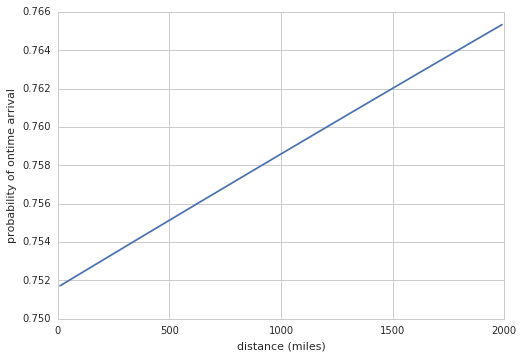

In [46]:
sns.set_style("whitegrid")
ax = plt.plot(dist, prob)
plt.xlabel('distance (miles)')
plt.ylabel('probability of ontime arrival')

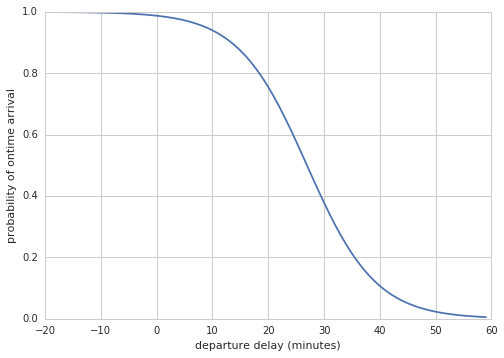

In [47]:
delay = np.arange(-20, 60, 1)
prob = [lrmodel.predict([d, 10, 500]) for d in delay]
ax = plt.plot(delay, prob)
plt.xlabel('departure delay (minutes)')
plt.ylabel('probability of ontime arrival')

<h2> Evaluate model </h2>

Evaluate on the test data

In [52]:
inputs = 'gs://{}/flights/tzcorr/all_flights-00001-*'.format(BUCKET) # you may have to change this to find a shard that has test data
flights = spark.read\
            .schema(schema)\
            .csv(inputs)
flights.createOrReplaceTempView('flights')
testquery = trainquery.replace("t.is_train_day == 'True'","t.is_train_day == 'False'")
print testquery


SELECT
  DEP_DELAY, TAXI_OUT, ARR_DELAY, DISTANCE
FROM flights f
JOIN traindays t
ON f.FL_DATE == t.FL_DATE
WHERE
  t.is_train_day == 'False' AND
  f.CANCELLED == '0.00' AND 
  f.DIVERTED == '0.00'



In [53]:
testdata = spark.sql(testquery)
examples = testdata.rdd.map(to_example)

In [54]:
testdata.describe().show()  # if this is empty, change the shard you are using

+-------+-----------------+------------------+------------------+-----------------+
|summary|        DEP_DELAY|          TAXI_OUT|         ARR_DELAY|         DISTANCE|
+-------+-----------------+------------------+------------------+-----------------+
|  count|            31721|             31721|             31721|            31721|
|   mean|22.06188329497809|17.100438195517164|18.437785694019734|861.5131301030863|
| stddev|55.27263492541411|  9.92470074434109| 58.42307362543692| 623.824325676582|
|    min|            -43.0|               1.0|             -65.0|             31.0|
|    max|           1239.0|             140.0|            1214.0|           4983.0|
+-------+-----------------+------------------+------------------+-----------------+



In [55]:
def eval(labelpred):
    cancel = labelpred.filter(lambda (label, pred): pred < 0.7)
    nocancel = labelpred.filter(lambda (label, pred): pred >= 0.7)
    corr_cancel = cancel.filter(lambda (label, pred): label == int(pred >= 0.7)).count()
    corr_nocancel = nocancel.filter(lambda (label, pred): label == int(pred >= 0.7)).count()
    
    cancel_denom = cancel.count()
    nocancel_denom = nocancel.count()
    if cancel_denom == 0:
        cancel_denom = 1
    if nocancel_denom == 0:
        nocancel_denom = 1
    return {'total_cancel': cancel.count(), \
            'correct_cancel': float(corr_cancel)/cancel_denom, \
            'total_noncancel': nocancel.count(), \
            'correct_noncancel': float(corr_nocancel)/nocancel_denom \
           }

# Evaluate model
lrmodel.clearThreshold() # so it returns probabilities
labelpred = examples.map(lambda p: (p.label, lrmodel.predict(p.features)))
print 'All flights:'
print eval(labelpred)

# keep only those examples near the decision threshold
print 'Flights near decision threshold:'
labelpred = labelpred.filter(lambda (label, pred): pred > 0.65 and pred < 0.75)
print eval(labelpred)

All flights:
{'correct_cancel': 0.8220530174844896, 'total_noncancel': 21083, 'correct_noncancel': 0.938765830289807, 'total_cancel': 10638}
Flights near decision threshold:
{'correct_cancel': 0.30975143403441685, 'total_noncancel': 461, 'correct_noncancel': 0.7700650759219089, 'total_cancel': 523}
